## Support Vector Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Support Vector Classifier model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from numpy import interp
import joblib

## IMPORT DATA

In [3]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))
X = features.drop('reportable_comp', axis=1)
y = pd.read_csv('02.data/target_categories_box_cox.csv', header=None, squeeze=True)

In [4]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

In [5]:
# svc seeks to find the optimal hyperplane
# which is influenced by the scale of the input features 
# as a result I will standardize the data before modeling
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(X))
X.columns = features.drop('reportable_comp', axis=1).columns

# must convert to array and reshape
# otherwise error message
y = scaler.fit_transform(np.array(y).reshape(-1, 1))
y = pd.Series(y[:,0])

## Support Vector Classifier

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [55]:
# randomly choose 10K rows
# to parameter tune on
feature_sample = pd.concat([
    X_train,
    y_train
], axis=1).sample(n=10000)

X_train_sample = feature_sample.drop(0, axis=1)
y_train_sample = feature_sample.loc[:, 0]

In [65]:
svc = SVC()

param_grid = { 
    'C': [1, 5, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'gamma': ['auto', 'scale'],
    'max_iter' : [500, 1000, 10000]
}

cv_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)
cv_svc.fit(X_train_sample, y_train_sample)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\Users\mrkjh\Miniconda3\lib\site-pack

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'gamma': ['auto', 'scale'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'max_iter': [500, 1000, 10000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [80]:
cv_svc.best_params_

{'C': 5, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 1000}

In [7]:
# save best parameters
joblib.dump({'C': 5, 
 'gamma': 'auto', 
 'kernel': 'rbf', 
 'max_iter': 1000}, '08.models/svc_params.pkl')

['08.models/svc_params.pkl']

In [8]:
svc = SVC(**joblib.load('08.models/svc_params.pkl'))

In [69]:
# fit model
svc.fit(X_train, y_train)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\svm\base.py:241: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [78]:
# save model
joblib.dump(svc, 'models/svc_model.pkl')

['models/svc_model.pkl']

In [120]:
# load model from pickel
svc = joblib.load('08.models/svc_model.pkl')

In [70]:
# train model
svc.score(X_train, y_train)

0.11234428321007375

In [71]:
# test model on unseen data
svc.score(X_test, y_test)

0.10915653653072231

In [72]:
# predict categores
pred = svc.predict(X_test)

In [73]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

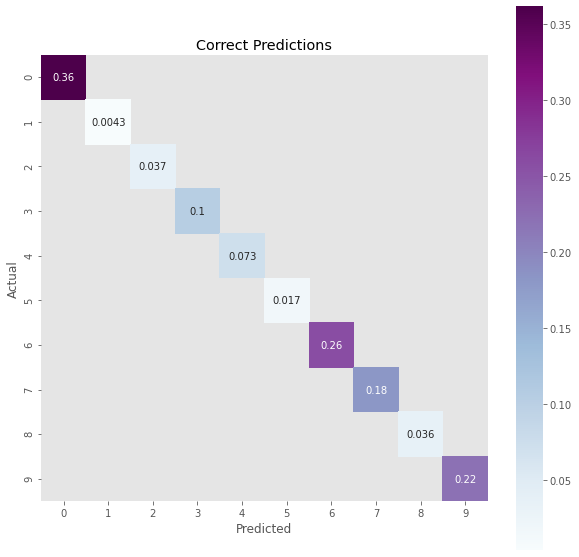

In [74]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

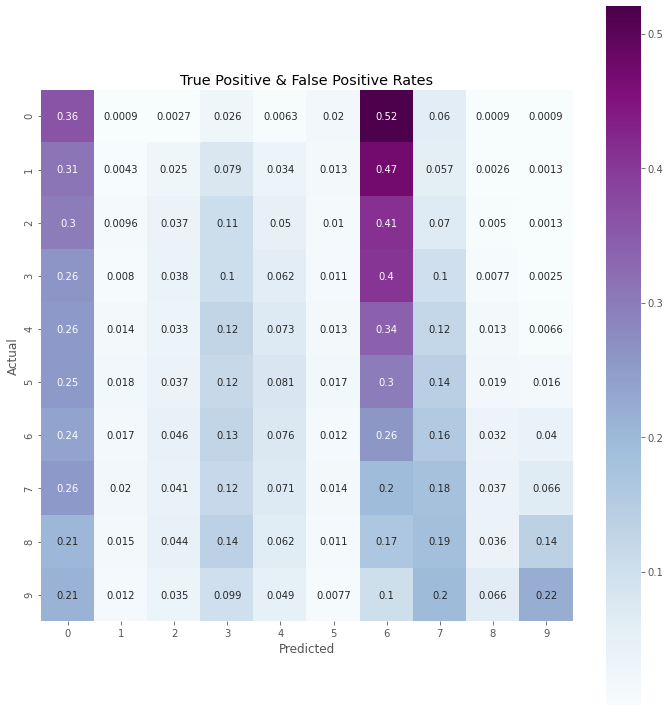

In [76]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('True Positive & False Positive Rates')
plt.tight_layout()
plt.savefig('03.visualizations/heat_map_svc.png');